<a href="https://colab.research.google.com/github/RebatiGaire/TensorflowInPractice/blob/master/Sequence_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc3


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
tf.keras.backend.clear_session()

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences= True)),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
     tf.keras.layers.Dense(1),
     tf.keras.layers.Lambda(lambda x: x * 200.0)


])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum=0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer= optimizer,
              metrics= ['mae'])

history = model.fit(dataset, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 10ms/step - loss: 18.8404 - mae: 19.2768 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 18.5166 - mae: 18.9695 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 18.1662 - mae: 18.6712 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 17.8393 - mae: 18.4094 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 17.7466 - mae: 18.1633 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 17.4857 - mae: 17.9428 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 17.1790 - mae: 17.7363 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 10ms/step - loss: 17.0210 - mae: 17.5302 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 10ms/step - loss: 16.7529 - mae:

(1e-08, 0.0001, 0.0, 30.0)

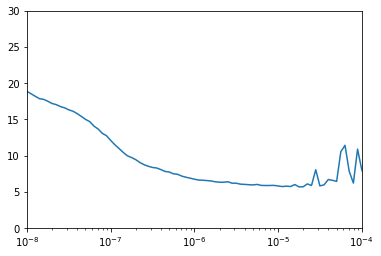

In [7]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 0s 7ms/step - loss: 19.8482 - mae: 20.5646
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 7.8943 - mae: 8.4048
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 6.7102 - mae: 7.1533
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 6.1493 - mae: 6.6477
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 5.7267 - mae: 6.1947
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 5.6667 - mae: 6.1487
Epoch 7/500
31/31 [==============================] - 0s 6ms/step - loss: 5.5069 - mae: 5.9842
Epoch 8/500
31/31 [==============================] - 0s 6ms/step - loss: 5.4465 - mae: 5.9422
Epoch 9/500
31/31 [==============================] - 0s 6ms/step - loss: 5.5342 - mae: 6.0318
Epoch 10/500
31/31 [==============================] - 0s 6ms/step - loss: 5.2315 - mae: 5.7214
Epoch 11/500
31/31 [==============================] - 0s 

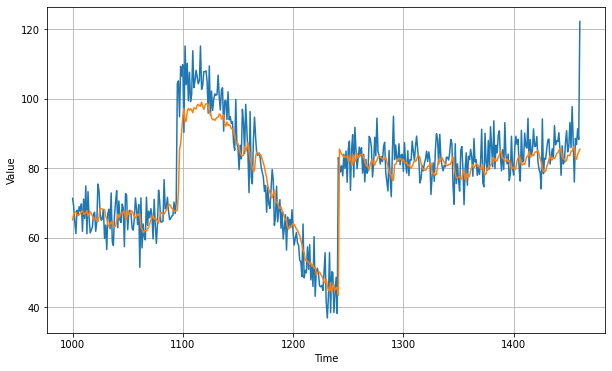

In [9]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.0903788

<Figure size 432x288 with 0 Axes>

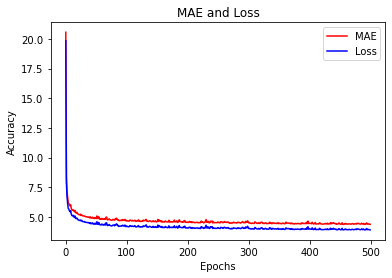

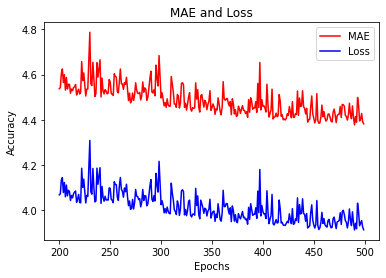

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()